In [19]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
%matplotlib inline

Сделать новый файл с матчами

In [20]:
def clean_json( in_file ):
    src = []
    with open( in_file, 'r', encoding='utf-8', newline='' ) as f:
        src = json.load(f)
    print(f"Loaded {len(src)} matches")
    dst = []
    for m in src:
        m_new = {}
        for k,v in m.items():
            if k in ["home", "away"]:
                m_new[k] = v["name"]
            # elif k == "quarters":
            #     m_new["q1"] = v["1"]
            #     m_new["q2"] = v["2"]
            #     m_new["q3"] = v["3"]
            #     m_new["q4"] = v["4"]
            #     m_new["ot"] = v["5"]
            elif k == "odds":
                m_new["odd_h"] = v["home"]
                m_new["odd_a"] = v["away"]
                for ttl in v['total']:                
                    if float( ttl[1] ) < 1.97  and float( ttl[2] ) < 2.0 :
                        m_new['total'] = ttl[0]
            elif k in ["score", "date"]:
                m_new[k] = v
        dst.append(m_new)   
    return dst

dst = clean_json( "matches.json" )

with open( "matches_clean.json", 'w', encoding='utf-8', newline='' ) as f:
    json.dump(dst, f, ensure_ascii=False, indent=4)

Loaded 443 matches


In [22]:
all_matches = pd.read_json("matches_clean.json" )
all_matches["score_h"] = all_matches["score"].apply( lambda x: int (x.split(":")[0] )  ) 
all_matches["score_a"] = all_matches["score"].apply( lambda x: int (x.split(":")[1] )  ) 
all_matches["total_sum"] = all_matches["score_h"] + all_matches["score_a"]
del all_matches["score"]


In [23]:
total = all_matches.copy()
total["delta"] = total["total_sum"] - total["total"]
del total["date"]
total = total.reset_index(drop=True)


In [24]:
total.tail()

,home,away,odd_h,odd_a,total,score_h,score_a,total_sum,delta
438,Торонто Рэпторс,Кливленд Кавальерс,1.70,2.16,217.0,108,105,213,-4.0
439,Детройт Пистонс,Орландо Мэджик,1.65,2.25,216.5,113,109,222,5.5
440,Индиана Пэйсерс,Вашингтон Уизардс,2.17,1.70,229.0,107,114,221,-8.0
441,Голден Стэйт Уорриорз,Лос-Анджелес Лейкерс,1.31,3.50,224.0,123,109,232,8.0
442,Бостон Селтикс,Филадельфия Сиксерс,1.67,2.22,216.5,126,117,243,26.5


In [139]:
import matplotlib as mpl
import matplotlib.lines as mlines

def get_team( team_name ) :    
    home = total[total["home"] == team_name][["odd_h", "total", "delta" ]]
    home = home.rename(columns={"odd_h": "odd", "match_score" : "match"})

    away =  total[total["away"] == team_name][["odd_a", "total", "delta" ]]
    away = away.rename(columns={"odd_a": "odd", "match_score" : "match"})
    team = pd.concat([home,away]).reset_index(drop=True)
    return team

def get_fav( val ):
    if val >= 1.0 and val < 1.5 :
        return "HIGH"
    elif val >= 1.5 and val < 2.0 :
        return "MED"
    elif val >= 2.0 and val < 3.0 :
        return "LOW"
    elif val >= 3.0  :
        return "FEW"
    
def complete_match(home, away, total):
    team = get_team(home)
    team["fav"] = team["odd"].apply( lambda x : get_fav(x) )
    team['id'] = "home"    
    team2 = get_team(away)
    team2["fav"] = team2["odd"].apply( lambda x : get_fav(x) )
    team2['id'] = "away"
    # data=pd.concat([team, team2])
    
    ax = team.plot.scatter(x="total", y="delta", label=home,  c='odd', colormap='cool')
    ax1 = team2.plot.scatter(x="total", y="delta", label=away, c='odd', colormap='cool')
    line_total = mlines.Line2D([float(total), float(total)], [float(total), float(total)], color='red')
    # ax.add_line(line_total)
    ax.plot([float(total), float(total), float(total)], [-50, 0, 30], 'y', ls='--')
    ax.plot([210,230],[0, 0], 'y', ls='--')
    ax1.plot([float(total), float(total), float(total)], [-50, 0, 30], 'y', ls='--')
    ax1.plot([210,230],[0, 0], 'y', ls='--')
    # ax1.add_line(line_total)
    # color="DarkBlue",color="DarkGreen", 
    # return data
#     g = sns.relplot(
        # data = data
#         x="total", y="delta",
#         hue = "fav", col="fav", size="id", style="id"
#     )
    
    

In [140]:
t = get_team("Филадельфия Сиксерс")


Loaded 114 matches
For Бруклин Нетс and Голден Стэйт Уорриорз with total 224.5 and odds: 1.10 :  7.20


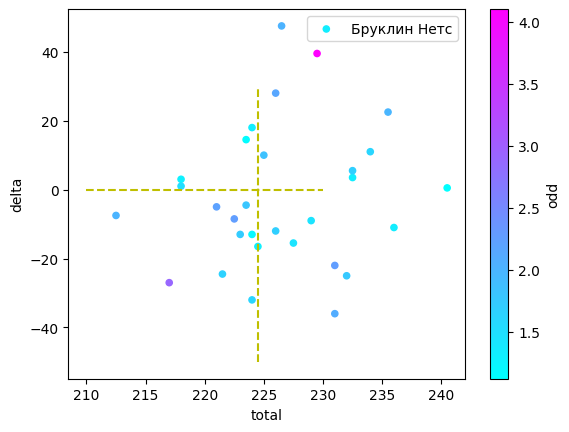

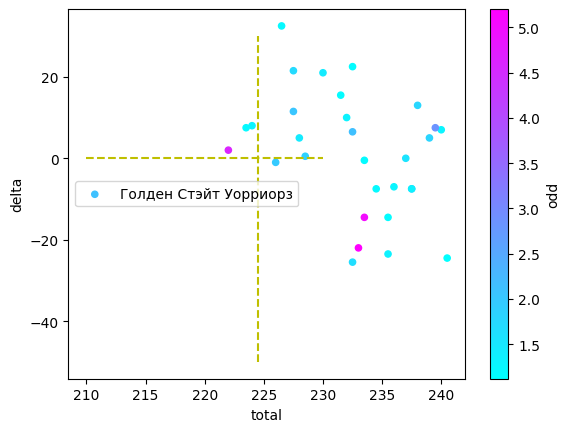

In [146]:
import datetime, json
import pandas as pd
src = []
with open( "matches_sched.json", 'r', encoding='utf-8', newline='' ) as f:
    src = json.load(f)
print(f"Loaded {len(src)} matches")
dst = []
for m in src:
    m_new = {}
    is_break = False
    for k,v in m.items():
        if k in ["home", "away"]:
            m_new[k] = v
        elif k == "odds":
            m_new["odd_h"] = v["home"]
            m_new["odd_a"] = v["away"]
            for ttl in v['total']:                
                if float( ttl[1] ) < 1.97  and float( ttl[2] ) < 2.0 :
                    m_new['total'] = ttl[0]
        elif k == "date":
            match_date =  pd.to_datetime(v)
            search_date =  datetime.datetime.now() + datetime.timedelta(days=1)
            if match_date > search_date:
                is_break = True
                break
    if is_break:
        break
    dst.append(m_new)

m = dst[4]
print( f"For {m['home']} and {m['away']} with total {m['total']} and odds: {m['odd_h']} :  {m['odd_a']}")
complete_match( m['home'], m['away'], m['total'] )
    